# Activation Maximization (AM)

Activation maximization is an explainability technique that generates synthetic input samples to maximize (or minimize) the output of a neural network model. By optimizing the input to strongly activate a particular neuron or output, we can gain insights into what patterns or features the model has learned to associate with high or low predictions.

Here we examine how the by-cell-lines activization maximizations differ from each other and the genral "prototypical AM output"
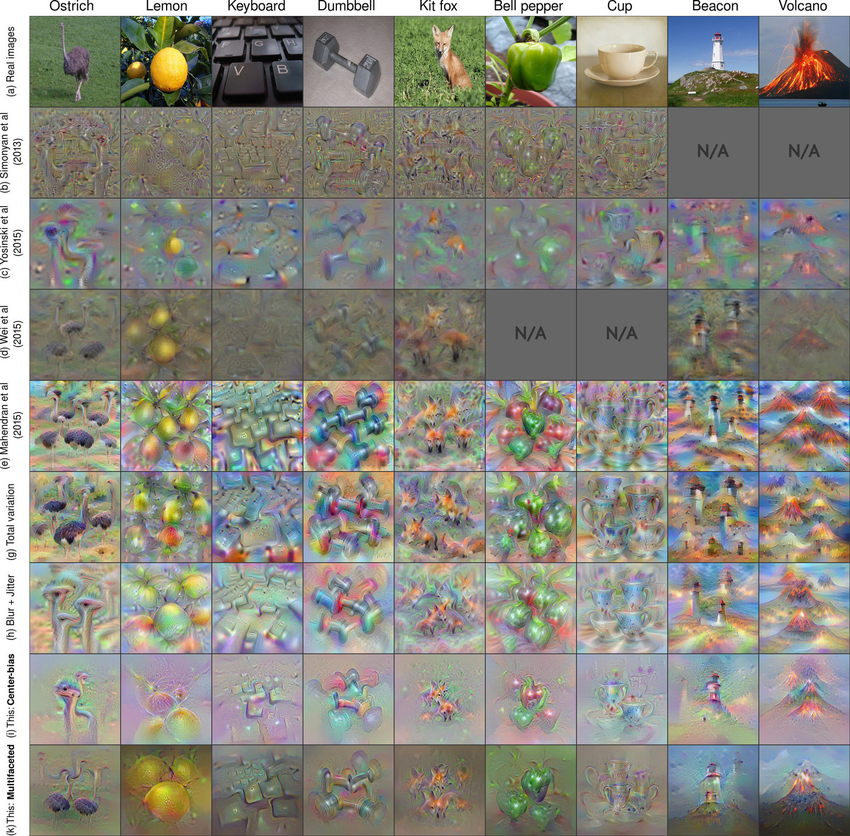

Since it is very important to NOT have the input (which is the output) of AM be on an edge of a manifold - we do regularize one variant (with L2) to the input distribution by using the mean of the distribution and penalising staying to far away from the z-score space of the input data (X).

In [2]:
import sys
from pathlib import Path
import os 

# Assuming this notebook is in: explainability/notebooks/
# So we go two levels up to reach the root where 'explainability/' lives
project_root = Path.cwd().parents[1]  # cwd = explainability/notebooks/
# join paths -> project root /explainability
explainability_path = project_root / "explainability"


sys.path.append(str(explainability_path))
os.chdir(project_root)

In [1]:
import os
os.getcwd()

'c:\\Users\\ismyn\\UNI\\FU Berlin\\SWP_Cancer\\Drug-Inhibitor-Cancer-Treatment\\explainability\\notebooks'

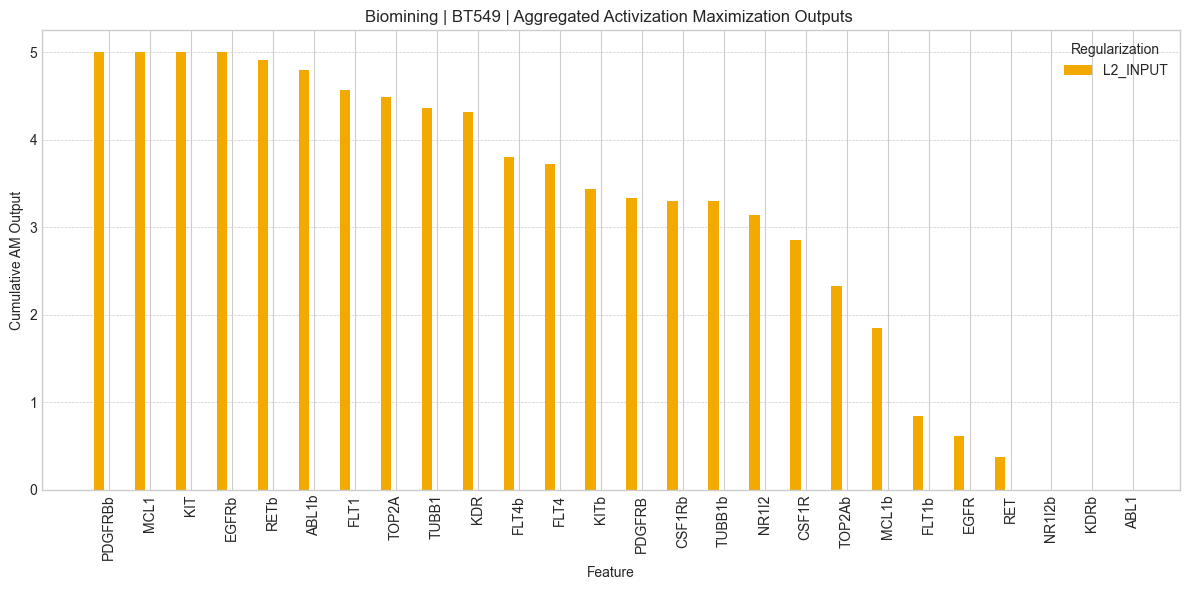

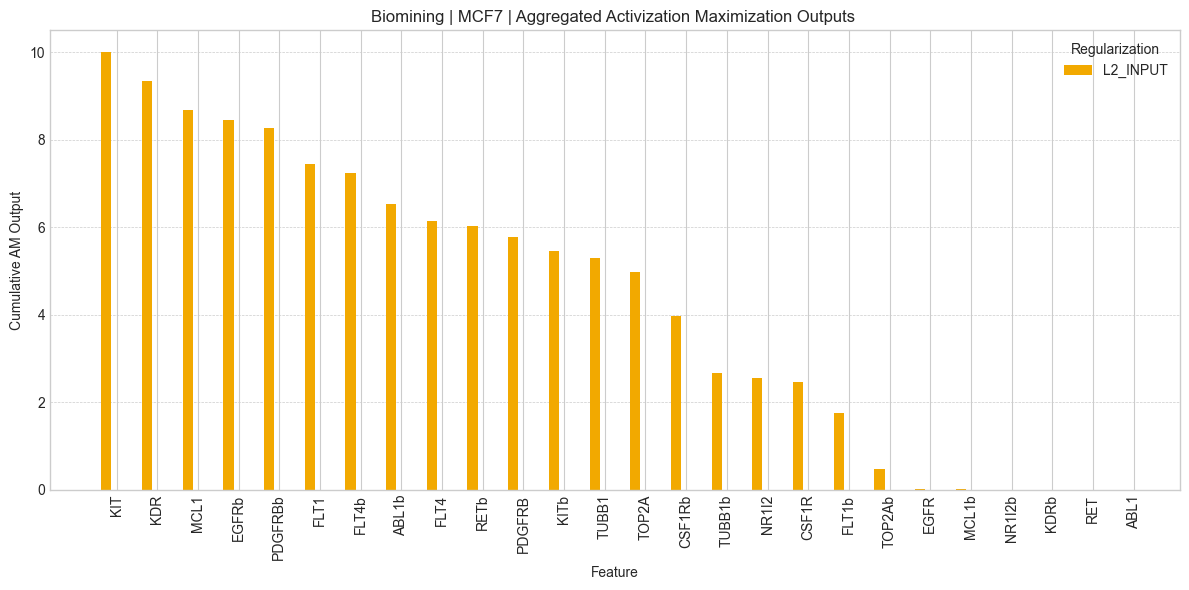

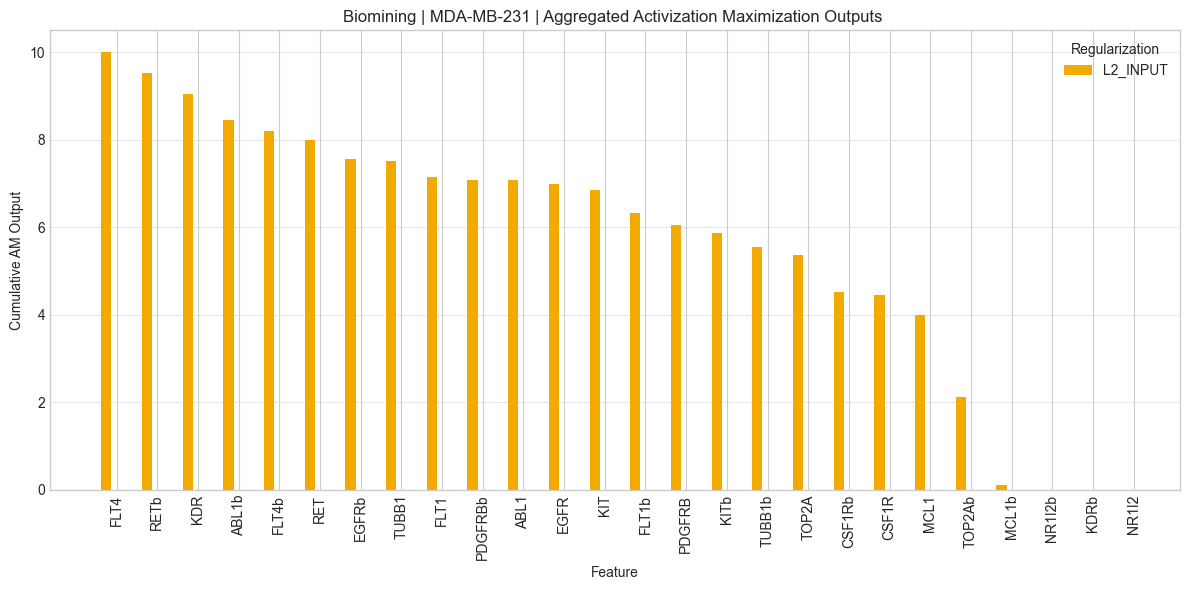

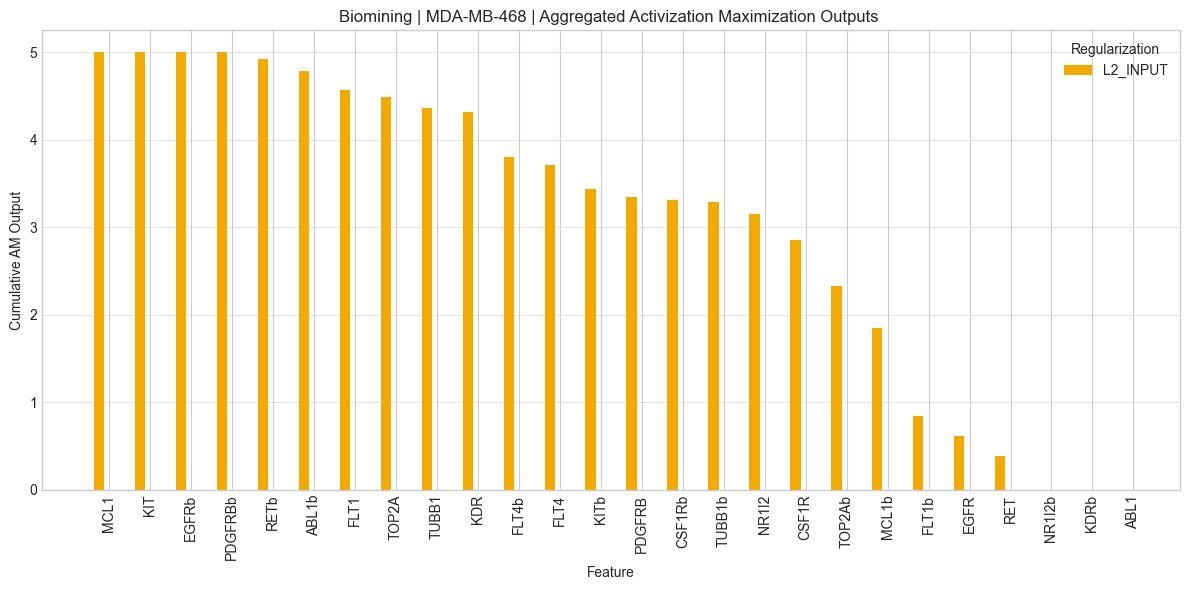

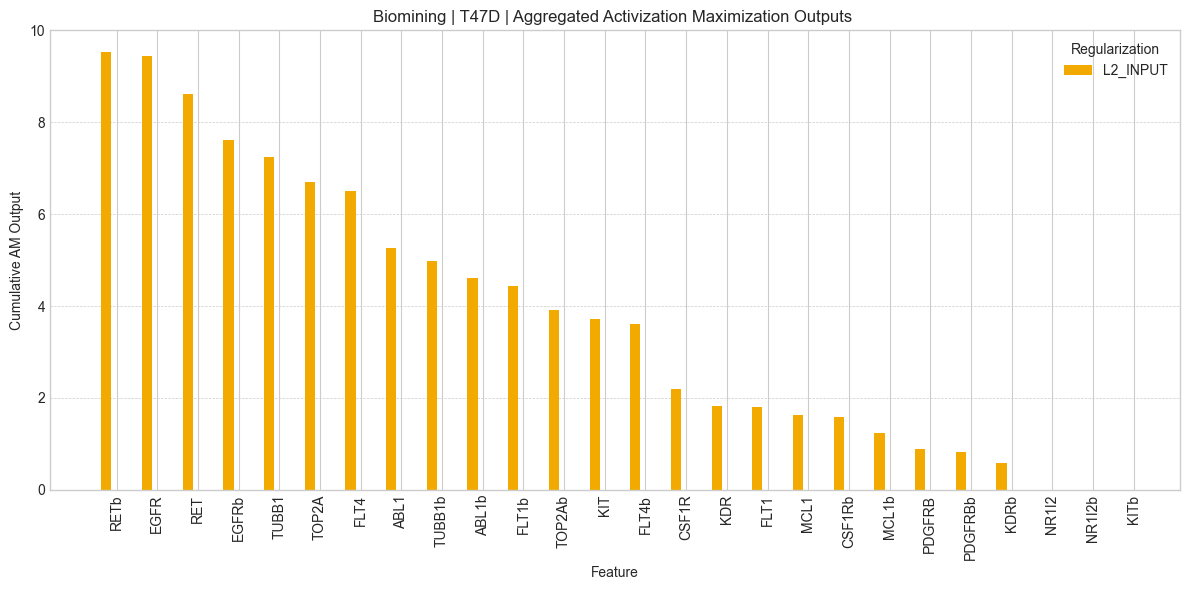

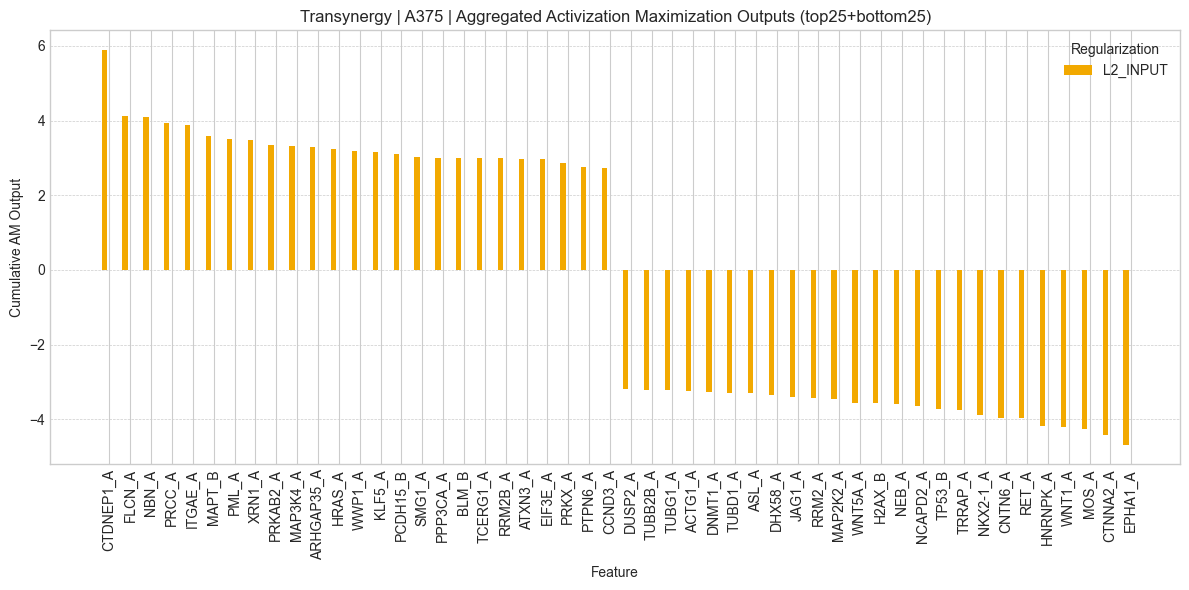

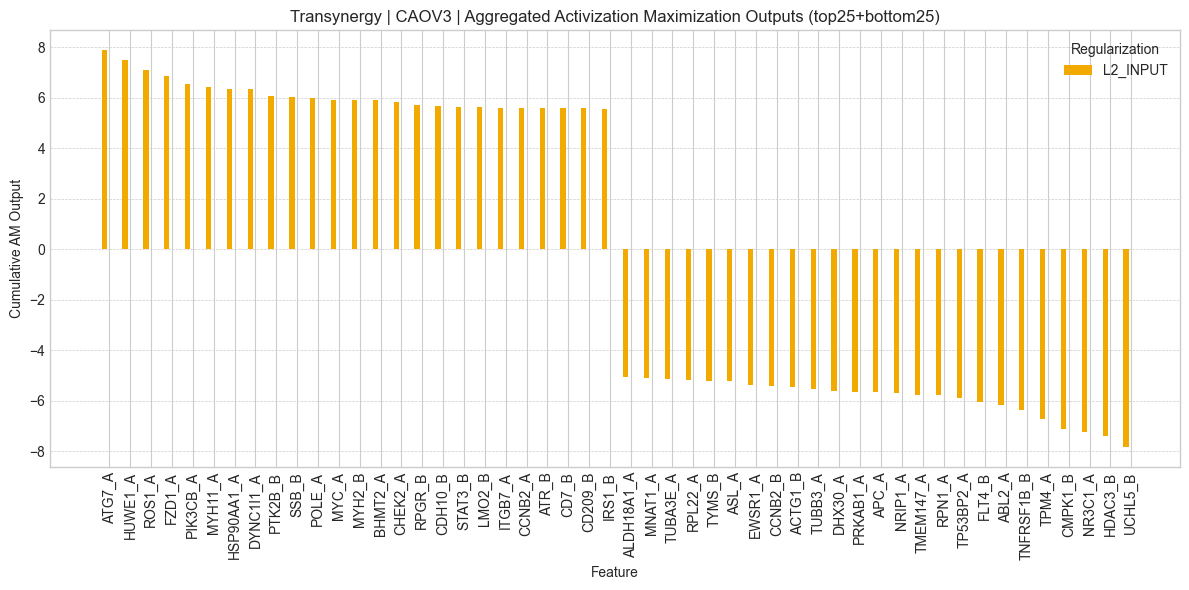

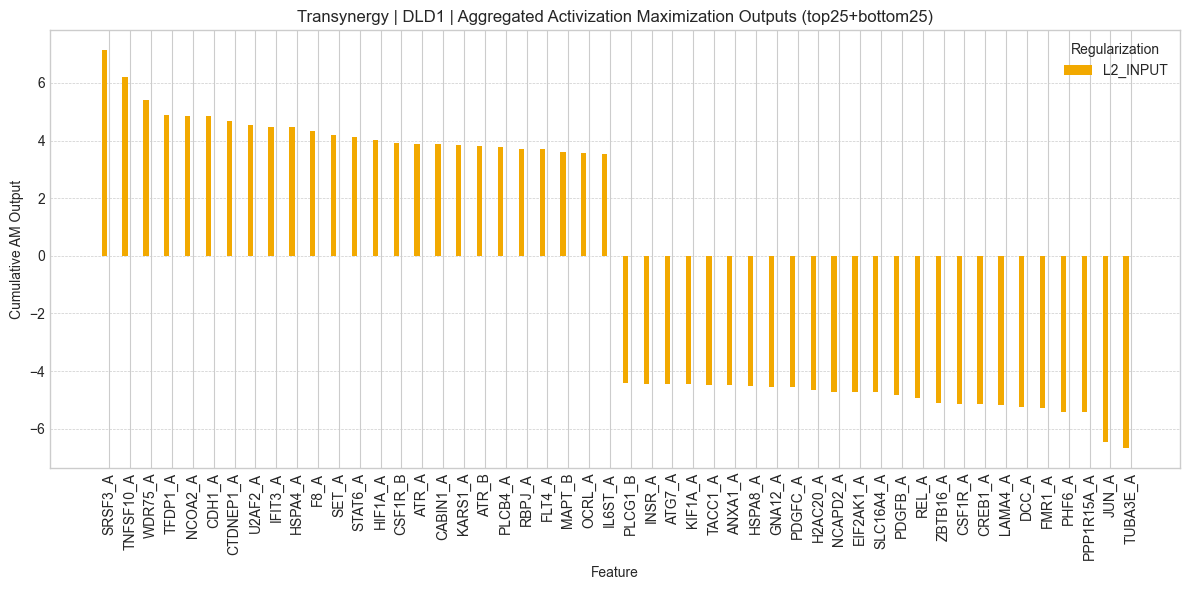

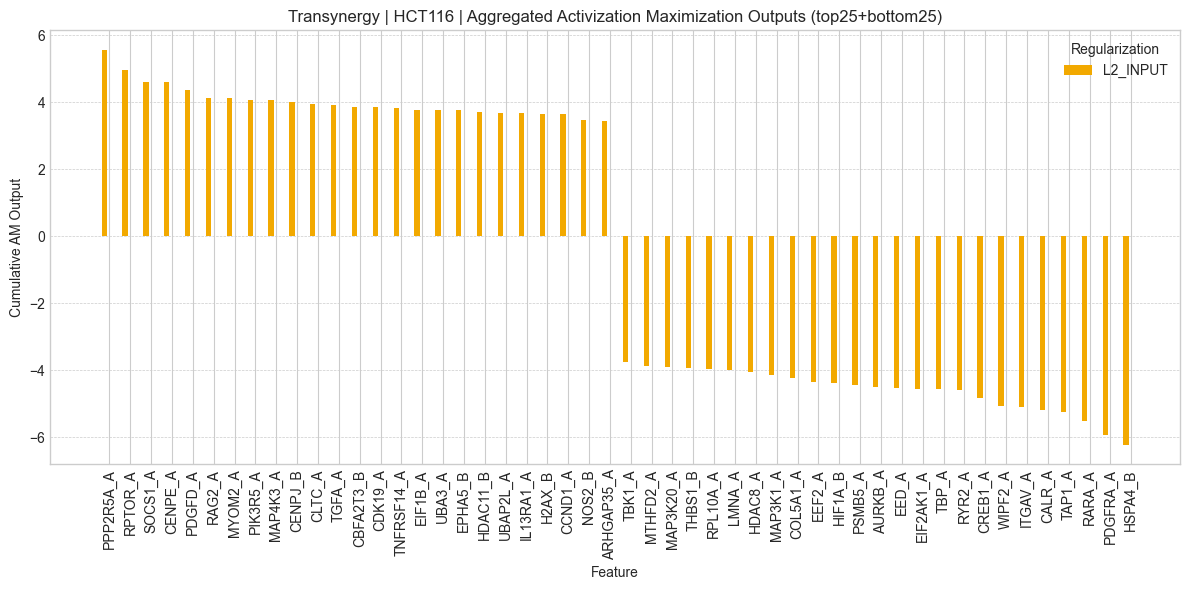

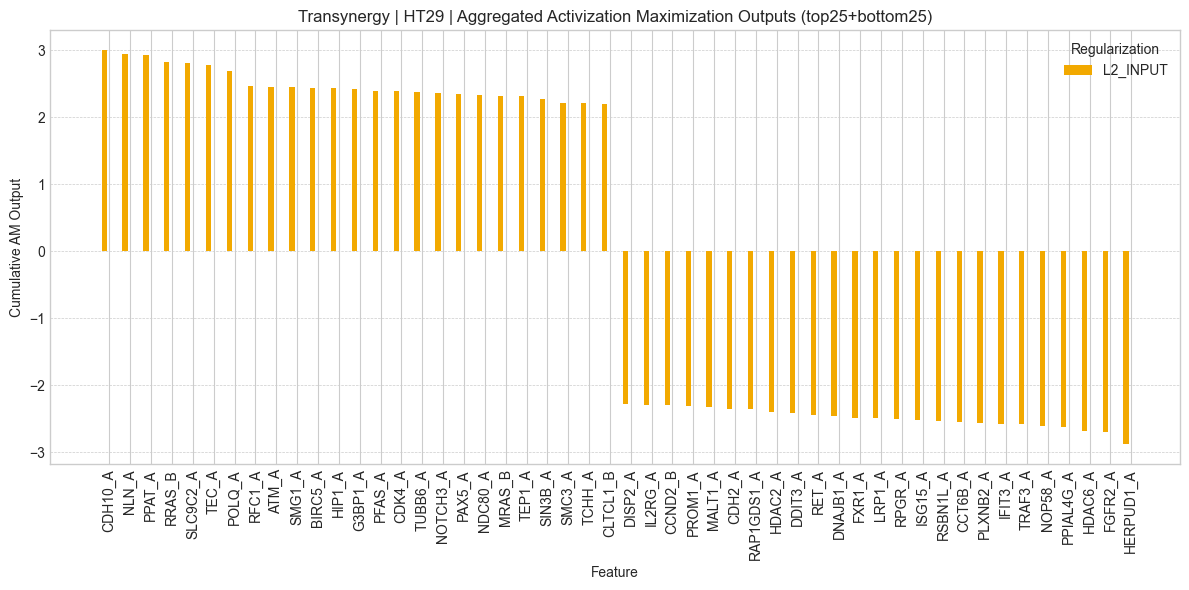

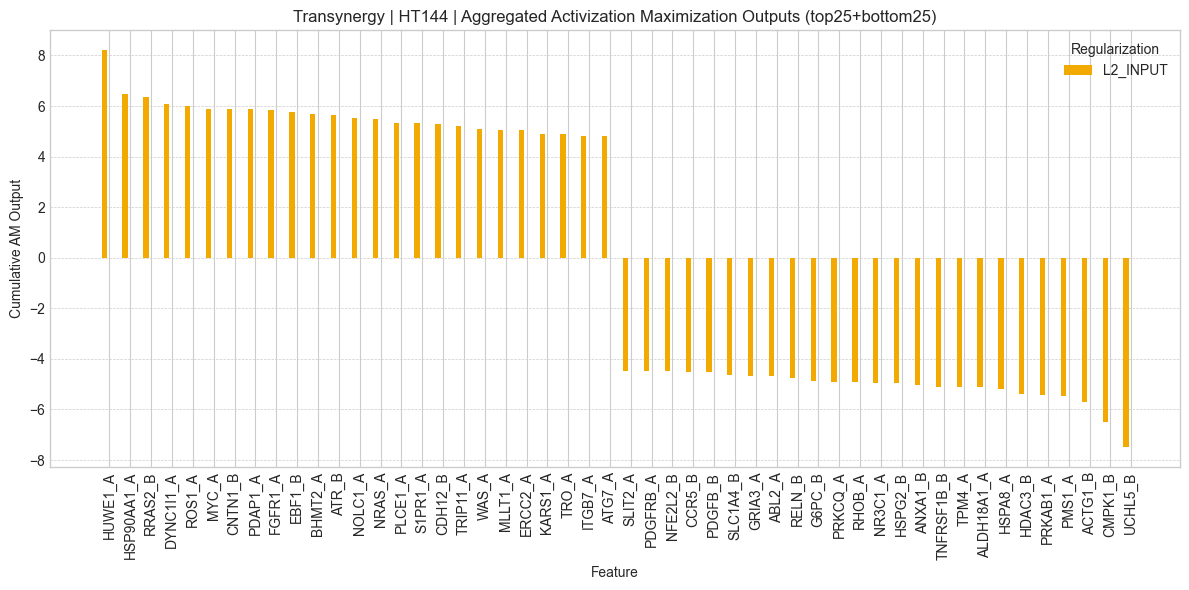

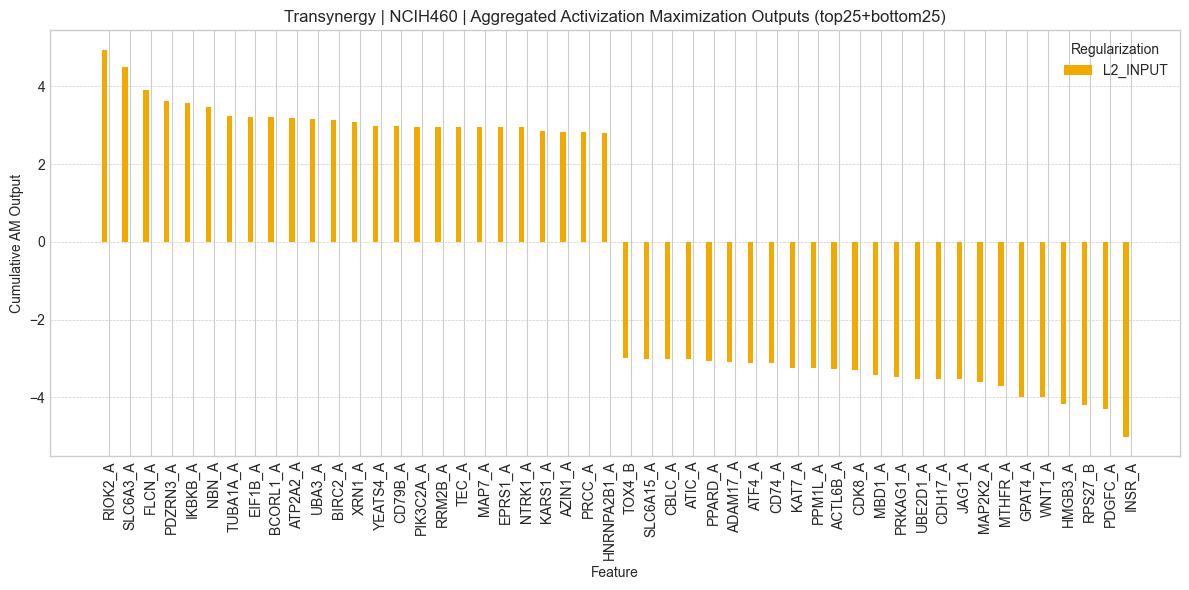

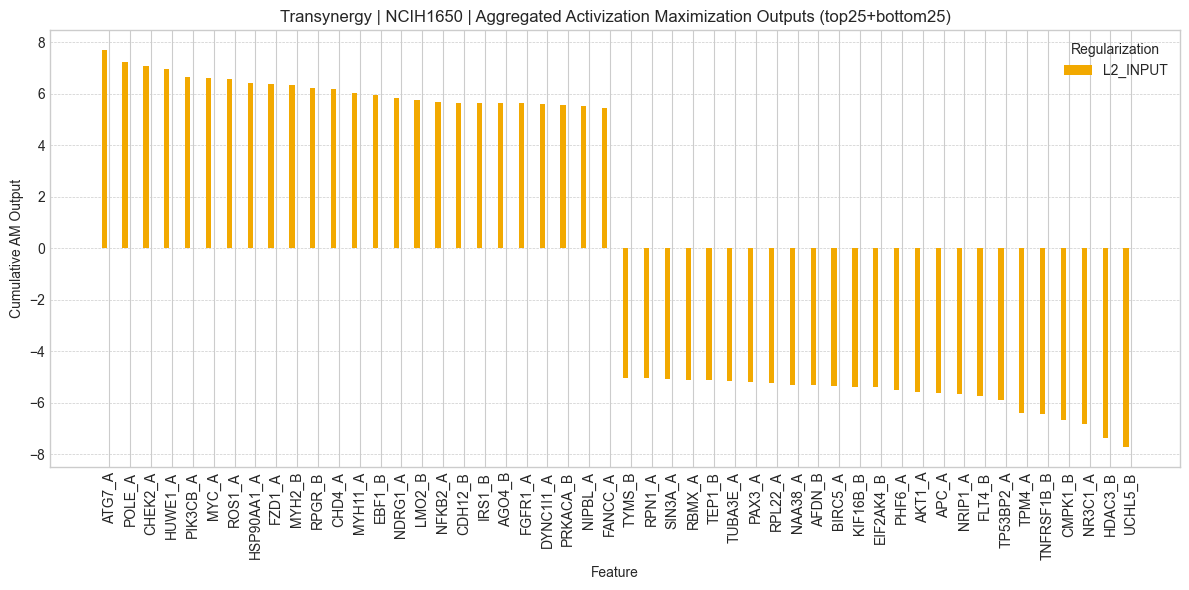

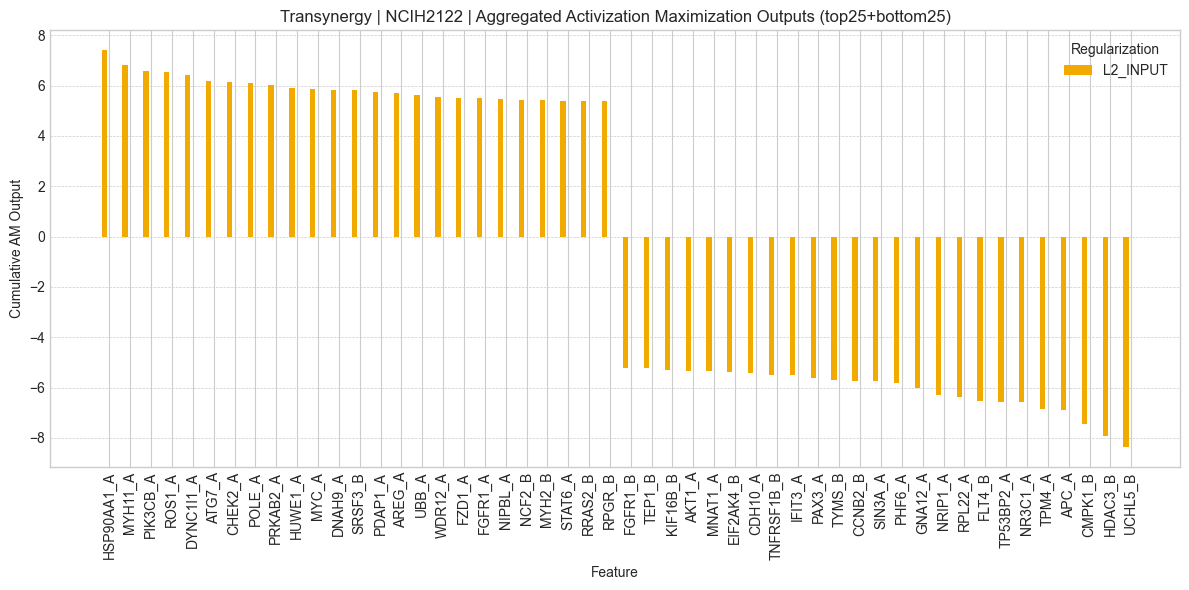

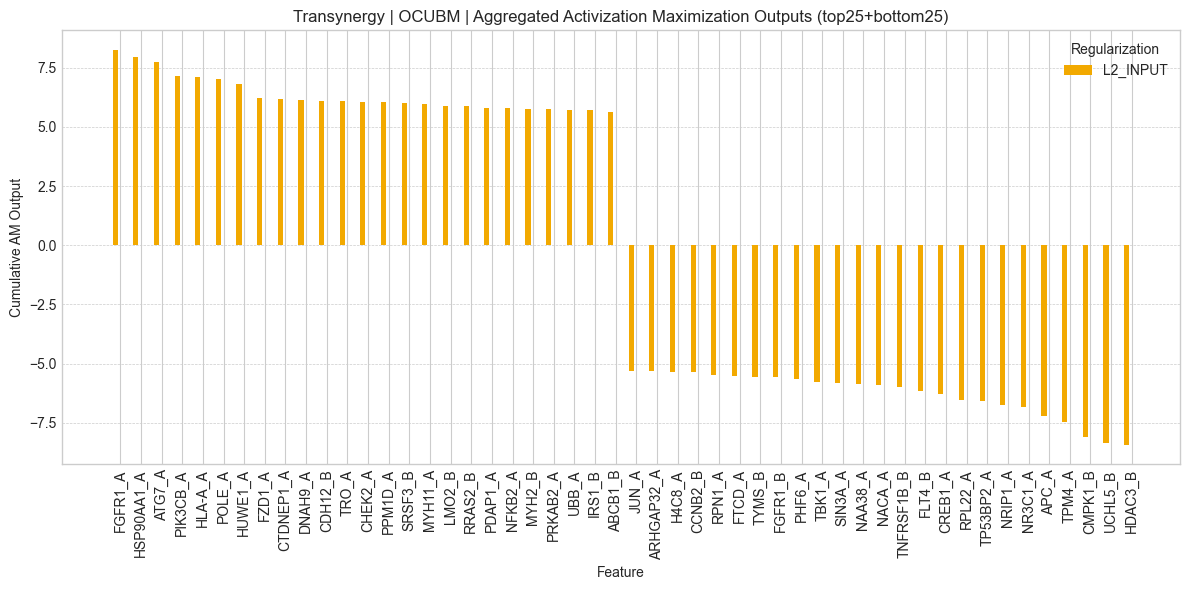

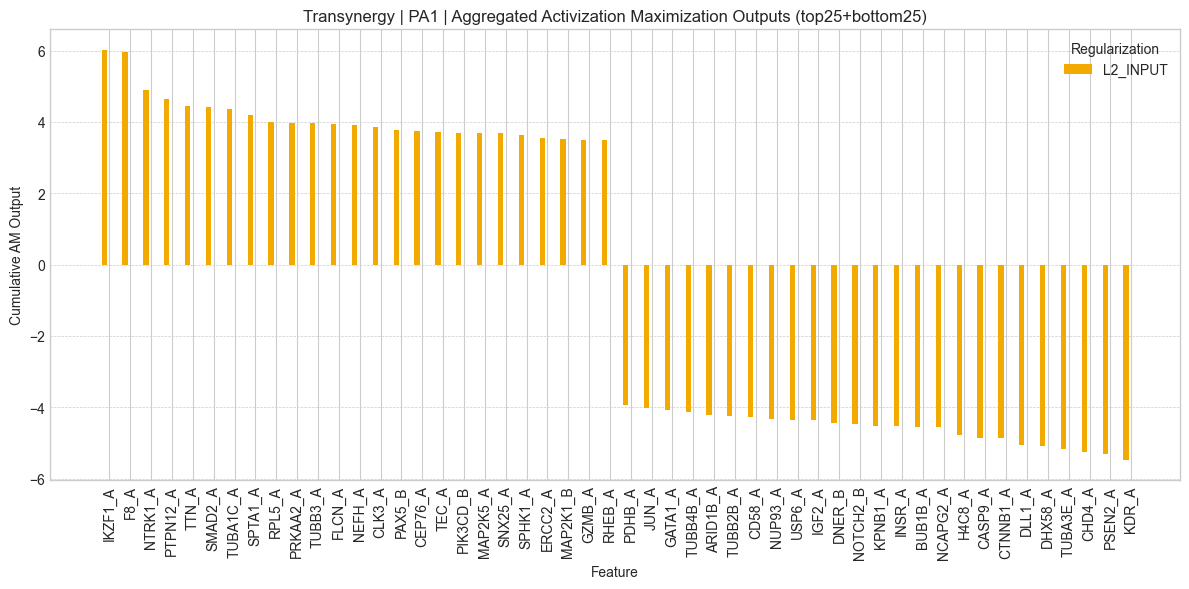

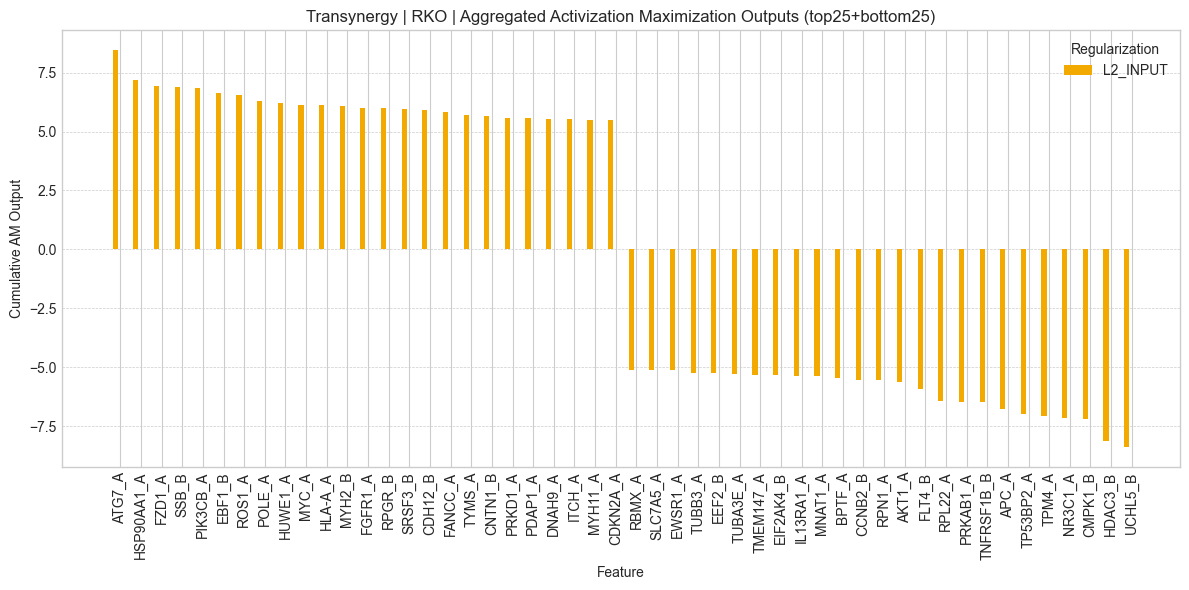

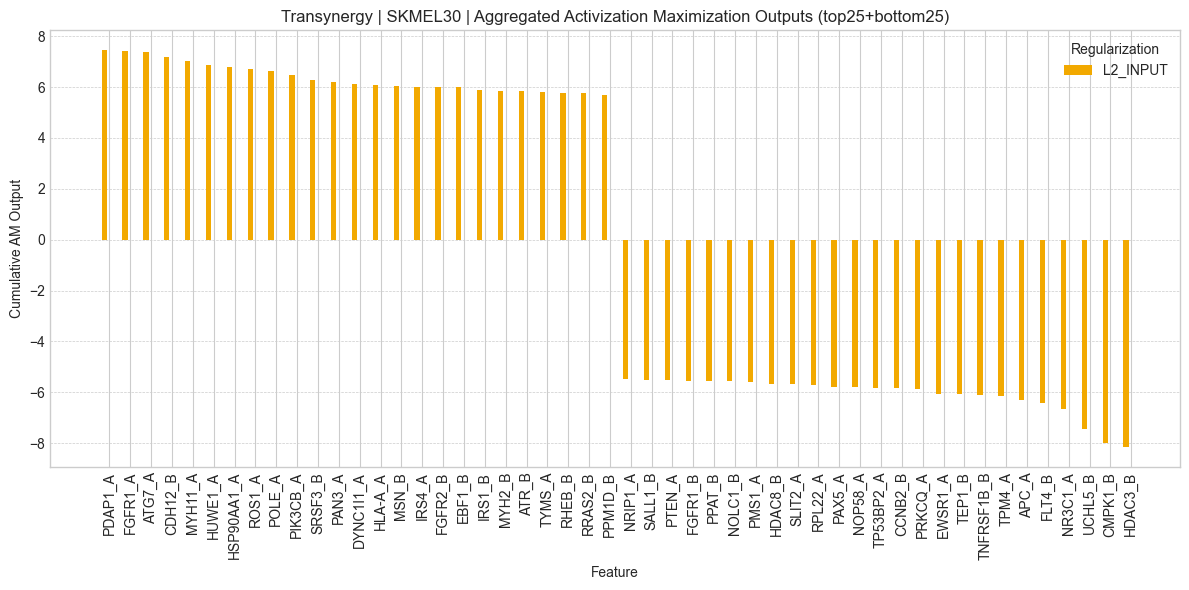

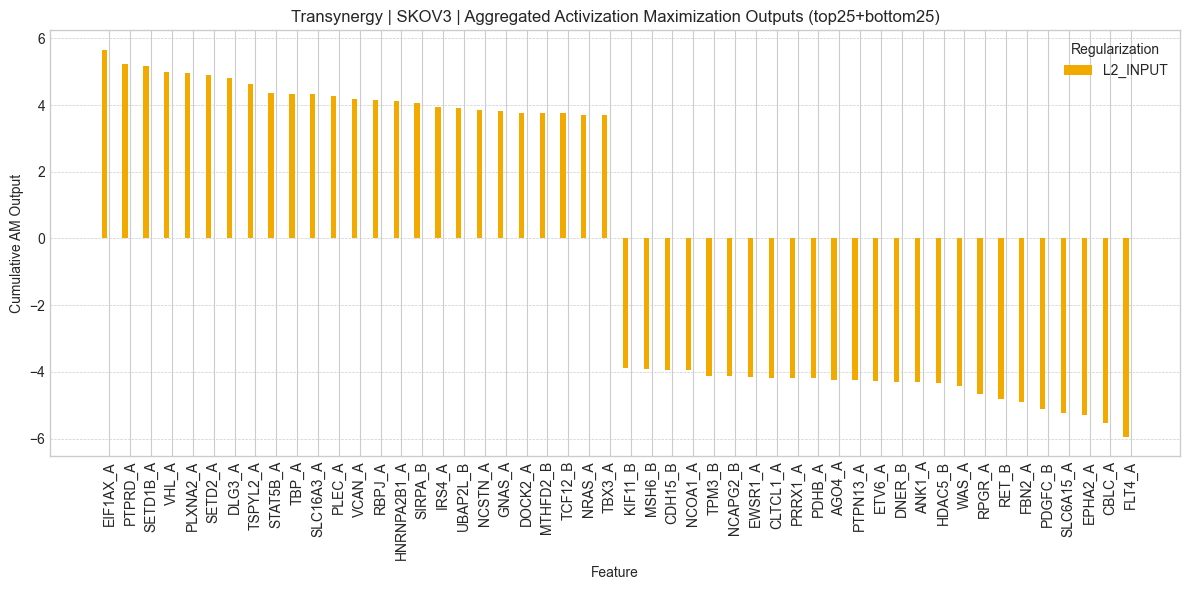

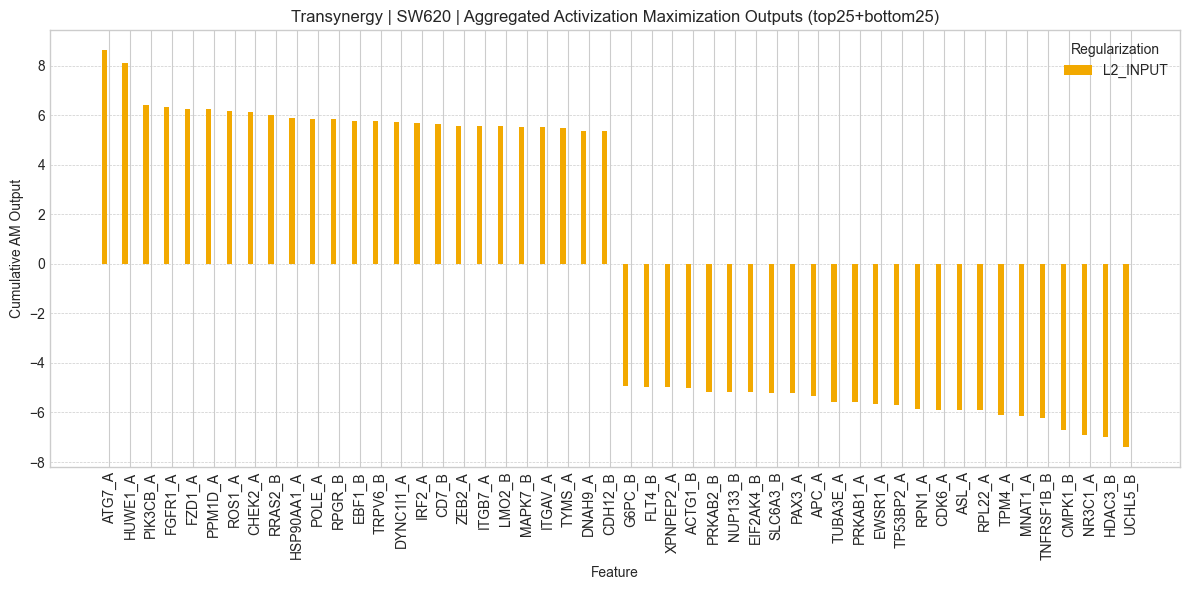

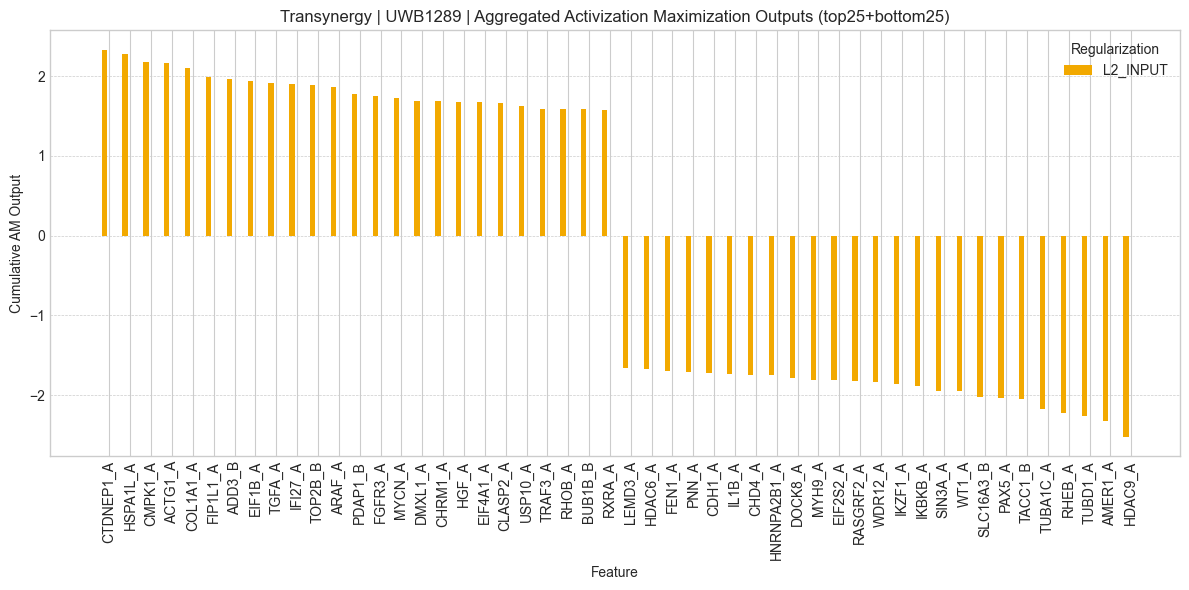

In [12]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from explaination_config import ExplainationConfig

plt.style.use("seaborn-v0_8-whitegrid")

regularizations = ["l2_input"]
colors = {
    "l2_input": "#F2A900"  # orange
}
minimaxis = ["max", "min"]
papers = ["biomining", "transynergy"]
cell_line_names = {
    'biomining': ["BT549", "MCF7", "MDA-MB-231", "MDA-MB-468", "T47D"],
    'transynergy': ["A375",
                    "CAOV3",
                    "DLD1",
                    "HCT116",
                    "HT29",
                    "HT144",
                    "NCIH460",
                    "NCIH1650",
                    "NCIH2122",
                    "OCUBM",
                    "PA1",
                    "RKO",
                    "SKMEL30",
                    "SKOV3",
                    "SW620",
                    "UWB1289"]
}
dict_papers_indices_l2 = {}
for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    cell_lines = cell_line_names[paper]
    for cell_line in cell_lines:
        SORTED_ORDER_INDICES = None
        feature_importance_all_regs = {}
        

        for reg in regularizations:
            path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/by_cell_line/{paper}_{cell_line}_max_reg_{reg}")
            feature_importance = torch.zeros(len(feature_names))
            for file in os.listdir(path_to_experiment):
                if file.endswith(".pt"):
                    tensor = torch.load(os.path.join(path_to_experiment, file))
                    feature_importance += tensor
                    
            importance_array = feature_importance.numpy()
            feature_importance_all_regs[reg] = importance_array.tolist()
            if paper == 'transynergy':
                index_max =  4804
            elif paper == 'biomining':
                index_max =  26
            if SORTED_ORDER_INDICES is None:
                # Sort based on this reg (first one in loop)
                full_sorted_indices = np.argsort(-importance_array)  # descending
                full_sorted_indices = full_sorted_indices.tolist()
                full_sorted_indices = [i for i in full_sorted_indices if i < index_max]  # Filter indices
                dict_papers_indices_l2[(paper, cell_line)] = full_sorted_indices
                if len(feature_names) > 50:
                    # Take top 25 and bottom 25
                    top_25 = full_sorted_indices[:25]
                    bottom_25 = full_sorted_indices[-25:]
                    SORTED_ORDER_INDICES = top_25 + bottom_25
                else:
                    SORTED_ORDER_INDICES = full_sorted_indices

        sorted_feature_names = [feature_names[i] for i in SORTED_ORDER_INDICES]
        # Aggregate feature importance across regularizations
        # Plot aggregated bar chart
        plt.figure(figsize=(12, 6))
        bar_width = 0.25
        x = range(len(SORTED_ORDER_INDICES))

        for idx, reg in enumerate(regularizations):
            sorted_values = [feature_importance_all_regs[reg][i] for i in SORTED_ORDER_INDICES]
            offset = [xi + (idx - 1) * bar_width for xi in x]  # shift bars
            plt.bar(offset, sorted_values, width=bar_width, label=reg.upper(), color=colors[reg])

        if len(feature_names) > 50:
            suffix = "(top25+bottom25)"
        else:
            suffix = ""
        plt.xticks(x, sorted_feature_names, rotation=90)
        plt.title(f"{paper.capitalize()} | {cell_line.upper()} | Aggregated Activization Maximization Outputs {suffix}")
        plt.xlabel("Feature")
        plt.ylabel("Cumulative AM Output")
        plt.legend(title="Regularization")
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.show()


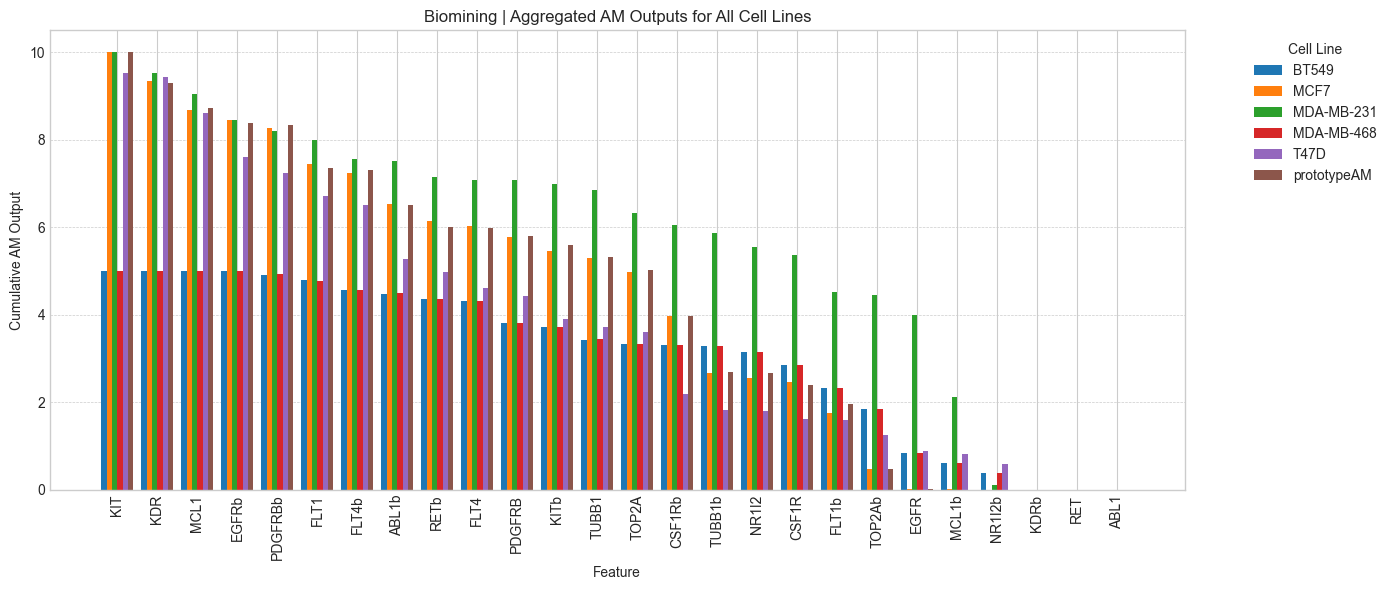

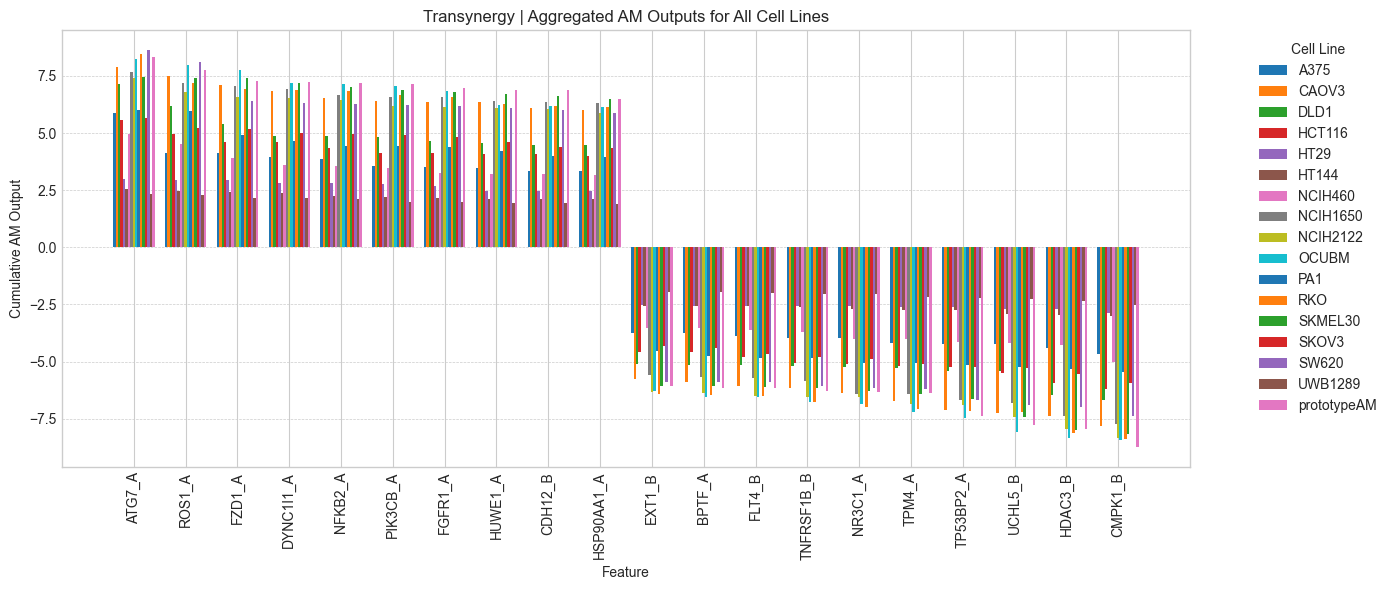

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from explaination_config import ExplainationConfig

plt.style.use("seaborn-v0_8-whitegrid")

regularizations = ["l2_input"]
colors = {
    "l2_input": "#F2A900"  # orange
}
papers = ["biomining", "transynergy"]
cell_line_names = {
    'biomining': ["BT549", "MCF7", "MDA-MB-231", "MDA-MB-468", "T47D", "prototypeAM"],
    'transynergy': ["A375", "CAOV3", "DLD1", "HCT116", "HT29", "HT144",
                    "NCIH460", "NCIH1650", "NCIH2122", "OCUBM", "PA1", "RKO",
                    "SKMEL30", "SKOV3", "SW620", "UWB1289", "prototypeAM"]
}
index_max_by_paper = {'biomining': 26, 'transynergy': 4804}

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    cell_lines = cell_line_names[paper]
    index_max = index_max_by_paper[paper]
    feature_importance_per_cell_line = {}

    # Collect importance per cell line
    for cell_line in cell_lines:
        if cell_line == 'prototypeAM':
            path_to_experiment = os.path.join(
            os.getcwd(), f"explainability/am/results/{paper}_max_reg_l2_input"
        )
        else:
            path_to_experiment = os.path.join(
            os.getcwd(), f"explainability/am/results/by_cell_line/{paper}_{cell_line}_max_reg_l2_input"
        )
        feature_importance = torch.zeros(len(feature_names))
        for file in os.listdir(path_to_experiment):
            if file.endswith(".pt"):
                tensor = torch.load(os.path.join(path_to_experiment, file))
                feature_importance += tensor

        importance_array = feature_importance.numpy()
        sorted_indices = np.argsort(-importance_array)
        sorted_indices = [i for i in sorted_indices if i < index_max]

        if len(feature_names) > 50:
            top_10 = sorted_indices[:10]
            bottom_10 = sorted_indices[-10:]
            final_indices = top_10 + bottom_10
        else:
            final_indices = sorted_indices

        feature_importance_per_cell_line[cell_line] = [importance_array[i] for i in final_indices]

    # Plot for one paper (all cell lines)
    #TODO: group by cell line by cancer type!
    plt.figure(figsize=(14, 6))
    x = np.arange(len(final_indices))
    bar_width = 0.8 / len(cell_lines)

    for idx, cell_line in enumerate(cell_lines):
        offset = x + (idx - len(cell_lines) / 2) * bar_width + bar_width / 2
        plt.bar(offset,
                feature_importance_per_cell_line[cell_line],
                width=bar_width,
                label=cell_line)

    sorted_feature_names = [feature_names[i] for i in final_indices]
    plt.xticks(x, sorted_feature_names, rotation=90)
    plt.title(f"{paper.capitalize()} | Aggregated AM Outputs for All Cell Lines")
    plt.xlabel("Feature")
    plt.ylabel("Cumulative AM Output")
    plt.legend(title="Cell Line", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()
